In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.model_selection import train_test_split
# models
import tensorflow as tf
import xgboost as xgb

In [70]:
with open('./Datasets/ToyotaCorolla.pkl','rb') as f:
    df = pickle.load(f)
    
df.head()

Price  Age     KM FuelType  HP  MetColor  Automatic    CC  Doors  Weight
0  13500   23  46986   Diesel  90         1          0  2000      3    1165
1  13750   23  72937   Diesel  90         1          0  2000      3    1165
2  13950   24  41711   Diesel  90         1          0  2000      3    1165
3  14950   26  48000   Diesel  90         0          0  2000      3    1165
4  13750   30  38500   Diesel  90         0          0  2000      3    1170

### Classification : more than 9800?

In [71]:
# preprocessing
df['y'] = df.Price.apply(lambda x:x>9800)
del df['Price']

lb = LabelBinarizer().fit(df.FuelType)

df = df.join(pd.DataFrame(lb.transform(df.FuelType), columns = ['FuelType_'+i for i in lb.classes_]))
del df['FuelType']

df.head()

Age     KM  HP  MetColor  Automatic    CC  Doors  Weight     y  \
0   23  46986  90         1          0  2000      3    1165  True   
1   23  72937  90         1          0  2000      3    1165  True   
2   24  41711  90         1          0  2000      3    1165  True   
3   26  48000  90         0          0  2000      3    1165  True   
4   30  38500  90         0          0  2000      3    1170  True   

   FuelType_CNG  FuelType_Diesel  FuelType_Petrol  
0             0                1                0  
1             0                1                0  
2             0                1                0  
3             0                1                0  
4             0                1                0

In [200]:
# dataset split - train, valid, test = 6:2:2
train, nottrain = train_test_split(df, test_size= 0.4)
valid, test = train_test_split(nottrain, test_size= 0.5)

In [78]:
rmse_dict = {}

In [79]:
# convert pd.DataFrame to DMatrix
dtrain = xgb.DMatrix(data=train.drop('y', axis=1), label=pd.DataFrame(train.y))
dvalid = xgb.DMatrix(data=valid.drop('y', axis=1), label=pd.DataFrame(valid.y))
dtest = xgb.DMatrix(data=test.drop('y', axis=1), label=pd.DataFrame(test.y))

In [234]:
param = {
    'max_depth':10, 
    'learning_rate':0.01, 
    'n_estimators':1000, 
    'eta':1, 
    'verbosity':0, 
    'objective':'binary:logistic',
#     'objective':'reg:linear', 
     'booster':'gbtree', 
    'n_jobs':4, 
    'nthread':4, 
    'gamma':0, 
    'base_score':0.5, 
    'random_state':0,
    'importance_type':'gain',
    'eval_metric':['error','auc']
#     'eval_metric':['rmse','mae'],
}
num_round = 1000

validtest = [(dtrain, 'train'), (dvalid, 'valid')]

# train
model = xgb.train(params=param, dtrain=dtrain, num_boost_round=num_round, evals=validtest, early_stopping_rounds = 500)

TypeError: invalid cache item: ndarray

In [167]:
# make prediction
preds = np.round(bst.predict(dtest, ntree_limit=bst.best_ntree_limit),0).astype(int)
print("f1 score is %0.2f" %f1_score(y_true=test.y.tolist(), y_pred=preds.tolist(), average='macro'))

f1 score is 0.82


In [201]:
train_y = train['y'].values
del train['y']
train_x = train.values

valid_y = valid['y'].values
del valid['y']
valid_x = valid.values

test_y = test['y'].values
del test['y']
test_x = test.values

In [204]:
dtrain = tf.keras.utils.normalize(train_x, axis=1)
dvalid = tf.keras.utils.normalize(valid_x, axis=1)
dtest = tf.keras.utils.normalize(test_x, axis=1)

In [233]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
# model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.softmax))

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy'])
model.fit(dtrain, train_y, epochs=3)

val_loss, val_acc = model.evaluate(dvalid, valid_y)
print('validation loss = ',val_loss, "\n",'validation accuracy= ',val_acc)

Epoch 1/3
861/861 [==============================] - 1s 830us/step - loss: 7.7212 - acc: 0.5157
Epoch 2/3
861/861 [==============================] - 0s 86us/step - loss: 7.7212 - acc: 0.5157
Epoch 3/3
287/287 [==============================] - 0s 930us/step
validation loss =  7.9434181372878445 
 validation accuracy=  0.5017421615248358


In [232]:
# 데이터가 너무 적다...

In [219]:
# model.save('epic_num_reader.model')
# new_model = tf.keras.models.load_model('epic_num_reader.model')
predictions = model.predict(test_x)

# print(np.argmax(predictions, axis = 1))

# plt.imshow(x_test[0])
# plt.show()

In [2]:
# ML vs DL in classification model

In [2]:
# 15개
COLUMNS = ["age", "workclass", "fnlwgt","education", "education_num", 
           "marital_status","occupation", "relationship", "race","gender", 
           "capital_gain", "capital_loss","hours_per_week", "native_country", "income_bracket"]

# 범주형 8개
CATEGORICAL_COLUMNS = ["workclass", "education", "marital_status",
                       "occupation", "relationship", "race",
                       "gender", "native_country"]

# 연속형 5개
CONTINUOUS_COLUMNS = ["age", "education_num", "capital_gain",
                      "capital_loss", "hours_per_week"]

df_train = pd.read_csv("./Datasets/adult.data.txt", names=COLUMNS, skipinitialspace=True)
df_test = pd.read_csv("./Datasets/adult.data.txt", names=COLUMNS, skipinitialspace=True, skiprows=1)
LABEL_COLUMN = 'label'

# 소득 50000달러 기준 binary classification
# df_train[LABEL_COLUMN] = (df_train['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)
# df_test[LABEL_COLUMN] = (df_test['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)

In [21]:
df = pd.concat([df_train, df_test], axis =0)
df[LABEL_COLUMN] = (df['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)
df.drop('income_bracket', axis = 1, inplace=True)

In [4]:
for ii in CATEGORICAL_COLUMNS:
    lb = LabelBinarizer()
    bi_x = lb.fit_transform(df[ii])
    df = df.join(pd.DataFrame(bi_x, columns=[ii+str(i) for i in range(bi_x.shape[1])])).drop(ii, axis=1)

In [5]:
train, nottrain = train_test_split(df, test_size= 0.4)
valid, test = train_test_split(nottrain, test_size= 0.5)

In [6]:
rmse_dict = {}

In [7]:
model = SVC(kernel='rbf', max_iter=1e5, gamma = 'auto')
model.fit(X=train.drop(['label'],axis=1), y=train.label)

est_Label = model.predict(X=valid.drop(['label'],axis=1))
valid_rmse = mean_squared_error(y_true=valid.label,y_pred=est_Label)
print("ACC of model with validation set is %2f" %(valid_rmse))

est_Label = model.predict(X=test.drop(['label'],axis=1))
test_rmse = mean_squared_error(y_true=test.label,y_pred=est_Label)
print("ACC of model with test set is %2f" %(test_rmse))

rmse_dict.update({"SVM":[valid_rmse, test_rmse]})

RMSE of model with validation set is 0.128225
RMSE of model with test set is 0.124299


In [9]:
model = RandomForestClassifier(n_estimators = 100)
model.fit(X=train.drop(['label'],axis=1), y=train.label)

est_Label = model.predict(X=valid.drop(['label'],axis=1))
valid_rmse = mean_squared_error(y_true=valid.label,y_pred=est_Label)
print("ACC of model with validation set is %2f" %(valid_rmse))

est_Label = model.predict(X=test.drop(['label'],axis=1))
test_rmse = mean_squared_error(y_true=test.label,y_pred=est_Label)
print("ACC of model with test set is %2f" %(test_rmse))

rmse_dict.update({"RandomForest":[valid_rmse, test_rmse]})

RMSE of model with validation set is 0.137899
RMSE of model with test set is 0.138810


In [11]:
model = XGBClassifier()
model.fit(X=train.drop(['label'],axis=1), y=train.label)

est_Label = model.predict(valid.drop(['label'],axis=1))
valid_rmse = mean_squared_error(y_true=valid.label,y_pred=est_Label)
print("ACC of model with validation set is %2f" %(valid_rmse))

est_Label = model.predict(test.drop(['label'],axis=1))
test_rmse = mean_squared_error(y_true=test.label,y_pred=est_Label)
print("ACC of model with test set is %2f" %(test_rmse))

rmse_dict.update({"XGBoost":[valid_rmse, test_rmse]})

RMSE of model with validation set is 0.159475
RMSE of model with test set is 0.163378


In [12]:
rmse_dict

{'SVM': [0.12822481572481573, 0.12429942418426104],
 'RandomForest': [0.1378992628992629, 0.13880998080614204],
 'XGBoost': [0.15947481572481573, 0.1633781190019194]}

In [13]:
result = pd.DataFrame(rmse_dict).T.rename(columns={0:'valid',1:'test'})

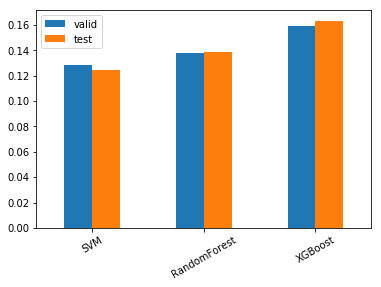

In [14]:
result.plot.bar(rot=0)
plt.xticks(rotation=30)
plt.show()

In [ ]:
# 딥러닝의 분류 정확성이 90%를 넘으면 승리!

In [22]:
df = pd.concat([df_train, df_test], axis =0)
df[LABEL_COLUMN] = (df['income_bracket'].apply(lambda x: '>50K' in x)).astype(int)
df.drop('income_bracket', axis = 1, inplace=True)

In [23]:
train, nottrain = train_test_split(df, test_size= 0.4)
valid, test = train_test_split(nottrain, test_size= 0.5)

In [24]:
# 범주형 
gender = tf.feature_column.categorical_column_with_vocabulary_list(
    key="gender", vocabulary_list=["Female", "Male"], dtype=tf.string)

race = tf.feature_column.categorical_column_with_vocabulary_list(
    key="race", vocabulary_list=["Amer-Indian-Eskimo", "Asian-Pac-Islander", "Black", "Other", "White"], 
    dtype=tf.string)

education = tf.feature_column.categorical_column_with_vocabulary_list(
    key="education", vocabulary_list=df_train.education.unique())

relationship = tf.feature_column.categorical_column_with_hash_bucket(
    key="relationship", hash_bucket_size=100, dtype=tf.string
)

workclass = tf.feature_column.categorical_column_with_hash_bucket(
    key="workclass", hash_bucket_size=100, dtype=tf.string
)

occupation = tf.feature_column.categorical_column_with_vocabulary_list(
    key="occupation", vocabulary_list=df_train.occupation.unique())

native_country = tf.feature_column.categorical_column_with_vocabulary_list(
    key="native_country", vocabulary_list=df_train.native_country.unique())

# 연속형 
age = tf.feature_column.numeric_column(key="age")

age_buckets = tf.feature_column.bucketized_column(source_column=age, 
                                                  boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

education_num = tf.feature_column.numeric_column(key="education_num")

capital_gain = tf.feature_column.numeric_column(key="capital_gain")

capital_loss = tf.feature_column.numeric_column(key="capital_loss")

hours_per_week = tf.feature_column.numeric_column(key="hours_per_week")

In [25]:
wide_columns = [
    gender, native_country, education, occupation, workclass, relationship, age_buckets,
    tf.feature_column.crossed_column([education, occupation], hash_bucket_size=int(1e4)),
    tf.feature_column.crossed_column([native_country, occupation], hash_bucket_size=int(1e4)),
    tf.feature_column.crossed_column([age_buckets, education, occupation], hash_bucket_size=int(1e6))
]
deep_columns = [
  tf.feature_column.embedding_column(workclass, dimension=5),
  tf.feature_column.embedding_column(education, dimension=8),
  tf.feature_column.embedding_column(gender, dimension=2),
  tf.feature_column.embedding_column(relationship, dimension=3),
  tf.feature_column.embedding_column(native_country, dimension=21),
  tf.feature_column.embedding_column(occupation, dimension=8),
  age, education_num, capital_gain, capital_loss, hours_per_week]

In [26]:
model = tf.estimator.DNNLinearCombinedClassifier(
    dnn_dropout=0.5,
    model_dir="./Models/test",
    linear_feature_columns=wide_columns,
    dnn_feature_columns=deep_columns,
    dnn_hidden_units=[256, 128, 64, 32, 16])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './Models/test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000011455CC0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [27]:
def input_fn(df):
    continuous_cols = {k: tf.constant(df[k].values)
                     for k in CONTINUOUS_COLUMNS}
    
    categorical_cols = {k: tf.SparseTensor(
            indices=[[i, 0] for i in range(df[k].size)], # 위치
            values=df[k].values, # 값
            dense_shape=[df[k].size, 1]) # 모양
                        for k in CATEGORICAL_COLUMNS}
    
    feature_cols = {**continuous_cols , **categorical_cols}

    label = tf.constant(df[LABEL_COLUMN].values)

    return feature_cols, label

def train_input_fn():
    return input_fn(train)

def valid_input_fn():
    return input_fn(valid)

def test_input_fn():
    return input_fn(test)

In [28]:
model.train(input_fn=train_input_fn, steps=100000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./Models/test\model.ckpt.
INFO:tensorflow:loss = 2867554.8, step = 1
INFO:tensorflow:global_step/sec: 1.43254
INFO:tensorflow:loss = 502999.25, step = 101 (69.810 sec)
INFO:tensorflow:global_step/sec: 1.45071
INFO:tensorflow:loss = 309052.3, step = 201 (68.937 sec)
INFO:tensorflow:global_step/sec: 1.50367
INFO:tensorflow:loss = 271644.3, step = 301 (66.498 sec)
INFO:tensorflow:global_step/sec: 1.57726
INFO:tensorflow:loss = 200776.78, step = 401 (63.408 sec)
INFO:tensorflow:global_step/sec: 1.45826
INFO:tensorflow:loss = 172935.44, step = 501 (68.568 sec)
INFO:tensorflow:global_step/sec: 1.41095
INFO:tensorflow:loss = 158067.42, step = 601 (70.883 sec)
INFO:tensorflow:global_step/sec: 1.23402
INFO:tensorflow

KeyboardInterrupt: 

In [29]:
results = model.evaluate(input_fn=valid_input_fn, steps=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-19-02:00:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Models/test\model.ckpt-5469
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-03-19-02:00:31
INFO:tensorflow:Saving dict for global step 5469: accuracy = 0.83607185, accuracy_baseline = 0.75852275, auc = 0.8820231, auc_precision_recall = 0.7034505, average_loss = 0.36612502, global_step = 5469, label/mean = 0.24147727, loss = 4768.412, precision = 0.7485236, prediction/mean = 0.24106184, recall = 0.48362482
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5469: ./Models/test\model.ckpt-5469


In [ ]:
pred_results = model.predict(input_fn = test_input_fn)

In [ ]:
for key in sorted(results):
    print("%s: %s" % (key, results[key]))